In [1]:
from functools import total_ordering
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from transforms import Normalize, PointSampler, RandomNoise, RandRotation_z, ToTensor
from dataset import PointCloudData
from model import PointNet
import open3d as o3d
from path import Path
import argparse
import sklearn
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from tqdm.notebook import tqdm
from utils import plot_class_wise_scores
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def fgsm_attack(model, criterion, point, labels, eps) :
    point.requires_grad = True
    outputs, _, _= model(point.transpose(1,2))
    model.zero_grad()
    loss = criterion(outputs, labels)
    loss.backward()
    attack_data = point + eps*point.grad.sign()
    return attack_data


In [4]:
def attack(model, criterion, point, label, eps, pointcloud_form=False):
  new_points = fgsm_attack(model, criterion, point, label, eps)
  outputs, __, __ = model(new_points.transpose(1,2))
  _, preds = torch.max(outputs.data, 1)
  if (pointcloud_form):
    pointcloud_vis = new_points.detach().cpu().numpy()
    pointcloud_vis = pointcloud_vis.reshape(-1,3)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pointcloud_vis)
    o3d.io.write_point_cloud("after_attack_new.ply",pcd)

  return preds

Attacking the pointnet using FGSM with epsilon  0.01


  0%|          | 0/15 [00:00<?, ?it/s]

Batch wise Accuarcy 15.6250
Batch wise Accuarcy 17.1875
Batch wise Accuarcy 43.7500
Batch wise Accuarcy 40.6250
Batch wise Accuarcy 3.1250
Batch wise Accuarcy 7.8125
Batch wise Accuarcy 29.6875
Batch wise Accuarcy 25.0000
Batch wise Accuarcy 14.0625
Batch wise Accuarcy 28.1250
Batch wise Accuarcy 17.1875
Batch wise Accuarcy 10.9375
Batch wise Accuarcy 15.6250
Batch wise Accuarcy 10.9375
Batch wise Accuarcy 25.0000
Accuracy: 20.0441


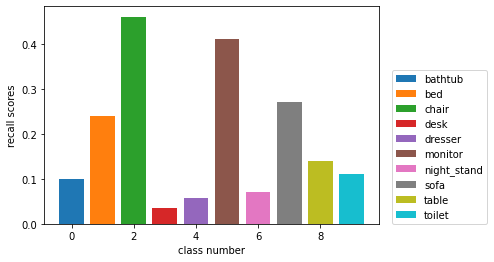

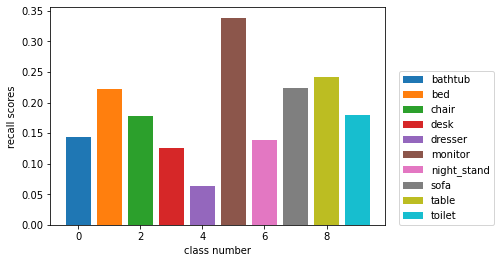

In [5]:
if __name__ == '__main__':
    path = Path("ModelNet10")
    train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

    test_dataset = PointCloudData(path, True, "test", train_transforms)
    model = PointNet()
    model = model.train()
    model = model.to(device)
    model.load_state_dict(torch.load("./save.pth"))
    fgsm_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    criterion = nn.NLLLoss()
    inv_classes = {i: cat for cat, i in test_dataset.classes.items()}
    total_targets = torch.zeros((0))
    total_preds = torch.zeros((0))
    total_accu = 0
    total_data_no = 0

    print("Attacking the pointnet using FGSM with epsilon ", 0.01)
    for i, data in enumerate(tqdm(fgsm_dataloader, position=0, leave=False)):
        labels = data['category']
        input_cloud = data['pointcloud']
        input_cloud = input_cloud.type(torch.FloatTensor)
        input_cloud = input_cloud.to(device)
        labels = labels.to(device)
        torch.cuda.empty_cache()
        preds = attack(model, criterion, input_cloud, labels, eps=0.01)
        
        acc = torch.sum(preds == labels) / preds.shape[0]
        total_accu += acc.item() * preds.shape[0]
        total_data_no += preds.shape[0]
        print("Batch wise Accuarcy {0:.4f}".format(acc.item()*100))
        total_preds = torch.cat([total_preds, preds.detach().cpu().squeeze()], dim=0)
        total_targets = torch.cat([total_targets, labels.detach().cpu().squeeze()], dim=0)
    
    total_targets = total_targets.detach().cpu().numpy()
    total_preds = total_preds.detach().cpu().numpy()
    confus_mat = confusion_matrix(total_targets, total_preds)
    recall_sco = recall_score(total_targets, total_preds, average=None)
    pre_sco = precision_score(total_targets, total_preds, average=None)
    print("Accuracy: {0:.4f}".format(total_accu *100 / total_data_no))
    plot_class_wise_scores(inv_classes, recall_sco, "recall scores")
    plot_class_wise_scores(inv_classes, pre_sco, "recall scores")